# XPCS Pipeline for GiSAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [192]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2, 
                        plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate)

from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                     get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             init_compress_eigerdata,
                                             Multifile,get_t_iqc,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)
from chxanalys.Create_Report import create_pdf_report

%matplotlib notebook

In [10]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [11]:
#%reset

In [12]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [13]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /XPCS_GiSAXS_Example_35e040.ipynb


## Make a directory for saving results

In [14]:
CYCLE = '2016_2'

username = getpass.getuser()

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')



##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'


os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [15]:
uid = '35e040' # Si Sample 1 - early time

In [16]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/35e040/


# Don't Change these lines below here

In [17]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  692--35e040ee-67b1-45ab-8de8-937956ffd233--/XF11ID/data/2016/06/18/e78140ce-1aea-435c-bb51_438


In [18]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/06/18/e78140ce-1aea-435c-bb51_438_master.h5


In [19]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong  
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'
print( 'The sample is %s' %md['sample'])


The sample is sample


In [20]:
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 20000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## Overwrite Some Metadata Due to Wrong Input

In [21]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'y_pixel_size': 7.5000004e-05, 'detector_distance': 4.8400002, 'beam_center_y': 1327.0, 'count_time': 0.099990003, 'x_pixel_size': 7.5000004e-05, 'frame_time': 0.1, 'beam_center_x': 1209.0, 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'sample': 'sample', 'incident_wavelength': 1.2846771, 'Measurement': 'Measurement'}


In [33]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.81      # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))

timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....



The sample is sample
Exposuretime=0.09999 sec, Acquisition_period=0.1 sec


In [34]:

setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe,  path= data_dir)

In [35]:
setup_pargs

{'Ldet': 4.81,
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'path': '/XF11ID/analysis/2016_2/yuzhang/Results/35e040/',
 'timeperframe': 0.1,
 'uid': '35e040'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [36]:

mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = '6fd155_6fd155_mask_scan1.npy'





<IPython.core.display.Javascript object>


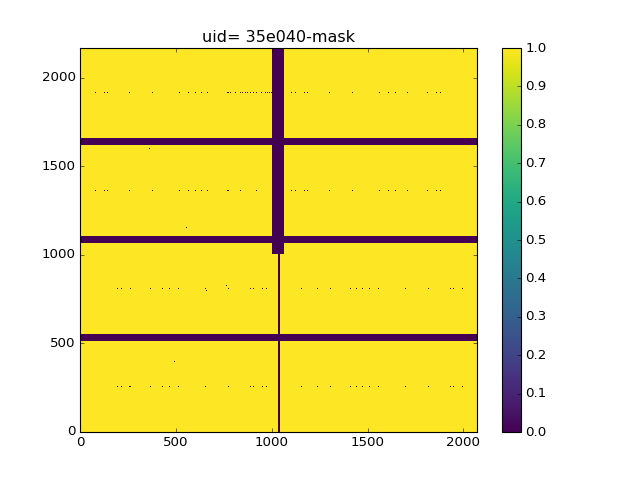

In [37]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )
mask = np.array( mask, dtype = np.int32)

In [38]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH


In [39]:
maskr = mask[::-1,:]
imgsr = reverse_updown( imgs )
imgsra = apply_mask( imgsr, maskr )

In [40]:
#show_img( imgsra[0],  vmin=0.1, vmax=100, logs=True, image_name= 'uid= %s'%uid) 

In [41]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


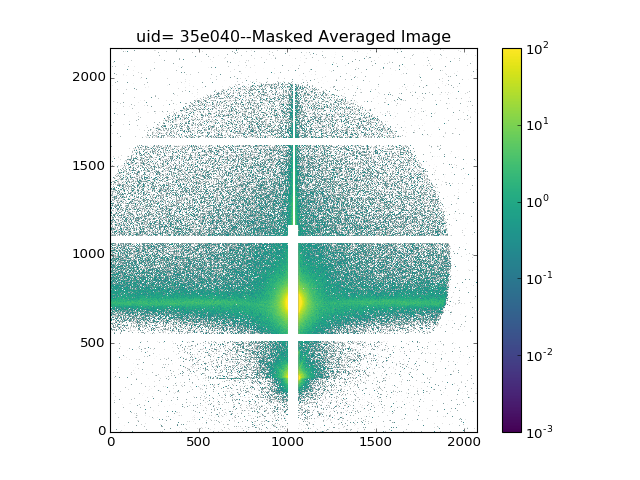

In [42]:
avg_imgr =  get_avg_img( imgsra, sampling = int(Nimg/3), plot_ = True, uid =uid)

In [43]:
#show_img( avg_imgr,  vmin= .01, vmax=500, logs= True, image_name= 'uid= %s'%uid) 

## Determine Compress Or Not
* For sake of simplicity, we always compress data 

In [44]:
print (len( np.where(avg_imgr)[0] ) / ( imgsra[0].size))
compress =  len( np.where(avg_imgr)[0] ) / ( imgsra[0].size) < 1  #if the photon ocupation < 0.1, do compress

print (compress)
#compress = False

0.27023869237508613
True


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [45]:
good_start = 0

In [46]:
if compress:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
    maskr, avg_imgr, imgsum, bad_frame_list = compress_eigerdata(imgsr, maskr, md, filename, 
                     force_compress= False, bad_pixel_threshold= 5e10,nobytes=4)    
    
    min_inten = 0    
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
    print ('The good_start frame number is: %s '%good_start)
    

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_35e040ee-67b1-45ab-8de8-937956ffd233.cmp.


Get each frame intensity: 100%|██████████| 20000/20000 [00:45<00:00, 442.16it/s]

No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


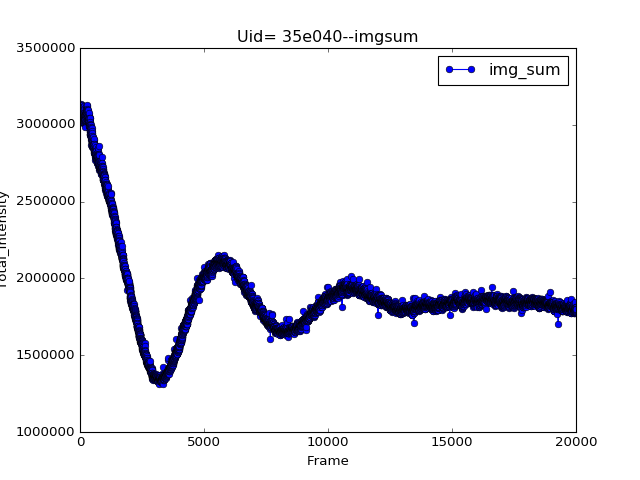

In [52]:
if compress: 
    FD = Multifile(filename, good_start, len(imgsr))    
    plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
           title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='img_sum'   )
    

In [53]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [54]:
bad_pixel_threshold= 8.6e15  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 7.5e5 #if re-define a bad pixel low threshold

In [55]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold,
                bad_pixel_low_threshold=bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)

## Define a good time series by defining a good start and good end

In [56]:
if False:
        good_start =0  #0
        min_inten = 10
        good_start =  max(good_start, np.where( np.array(imgsum) > min_inten )[0][0])    
        good_end =     len(imgsr)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD, bad_pixel_threshold= bad_pixel_threshold,
                    bad_pixel_low_threshold=bad_pixel_low_threshold, plot_=False )                           


In [57]:
if not compress:   
    #sampling = 1   #sampling should be one    
    sampling = 100  #sampling should be one     
    
    good_start = check_shutter_open( imgsra,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = max(good_start, apply_mask( imgsra[good_start:], maskr ))
    avg_imgr =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold=1.2e8,  plot_ = False, uid=uid)
    
    

In [58]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 0 
The good_start frame number is: 0 


In [59]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
           

<IPython.core.display.Javascript object>


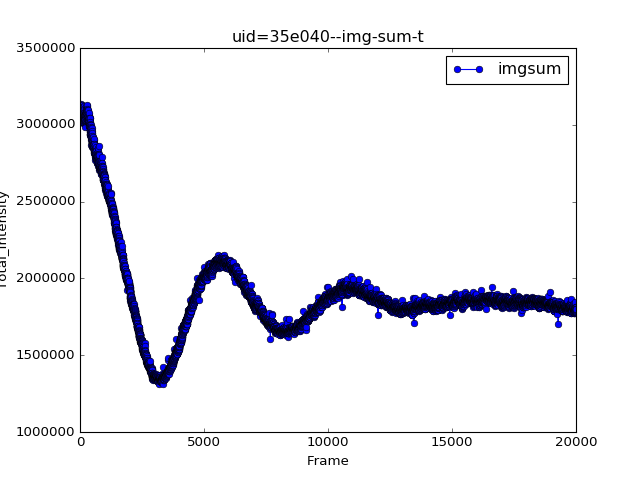

In [60]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


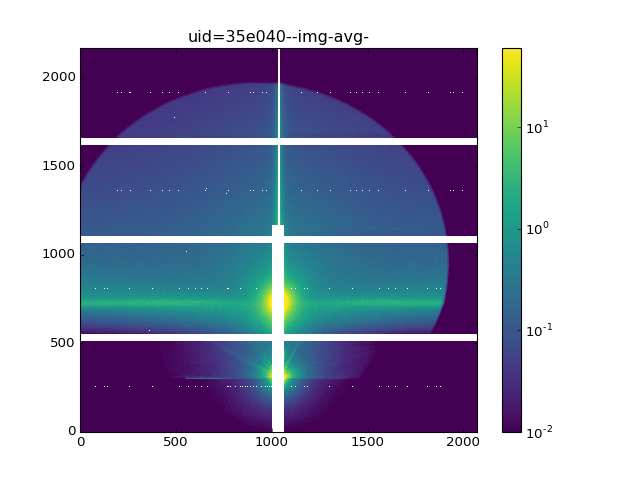

In [61]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_imgr,  vmin=0.01, vmax= 60.0, logs=True, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_imgr

## Get Q-Map (Qz and Qr)
* Users put incident-Beam and Reflection_Beam Centers here!!!


# Change these lines

 

In [62]:

inc_x0 = 1038
inc_y0 = 299

refl_x0 = 1038
refl_y0 = 725

# Don't Change these lines below here

In [63]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )

The incident_angle (alphai) is: 0.190288277872
The incident_angle (alphai) is: 0.190288277872


<IPython.core.display.Javascript object>


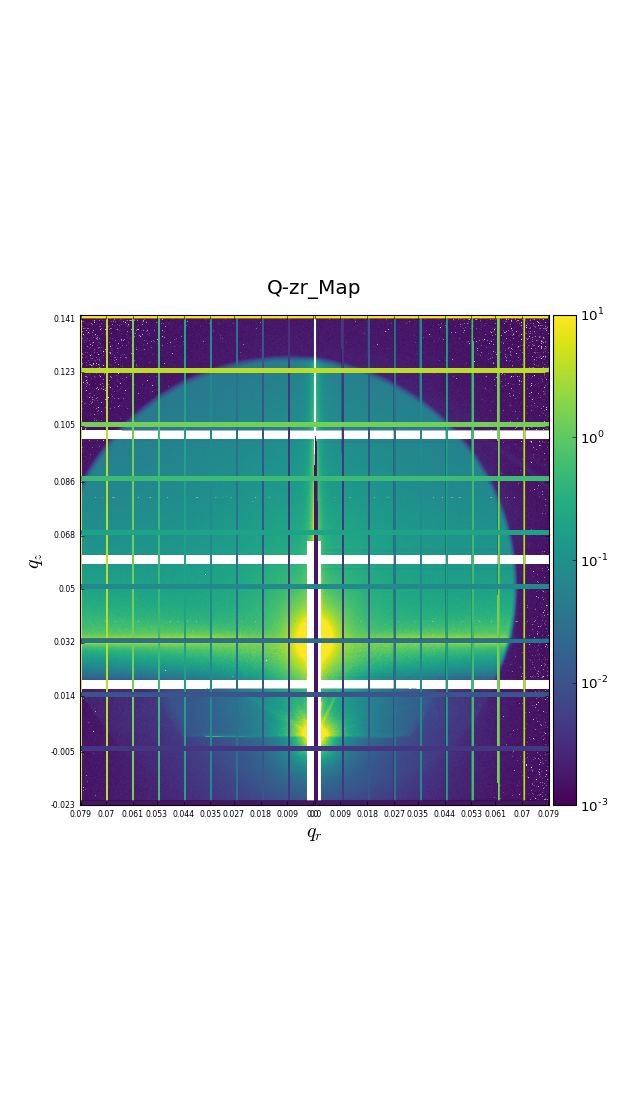

In [64]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

## Define Q-ROI
* User provide the interested Qz and Qr here for XPCS analysis

# Change these lines

In [112]:
# Go across Qr
qz_start = 0.022
qz_end = 0.045
qz_num= 2
qz_width = 0.01 #(qz_end - qz_start)/(qz_num+1)


qr_start =  0.005
qr_end = 0.08
qr_num = 7
qr_width = 0.01 # ( qr_end- qr_start)/qr_num

Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

# Don't Change these lines below here

* Create label array (Qz, Qr, Qzr boxes)

In [113]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)


labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))

* Extract the labeled array

In [114]:
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

In [115]:
md['ring_mask'] = box_maskr
md['qr_center']= qr_center
md['qr_edge'] = qr_edge
md['qz_center']= qz_center
md['qz_edge'] = qz_edge
md['beam_center_x'] = inc_x0
md['beam_center_y']=  inc_y0
md['refl_center_x'] = refl_x0
md['refl_center_y']=  refl_y0
md['incident angle'] = alphai*180/np.pi

psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

* Number of pixels in each q box

In [116]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([34322, 34312, 34322, 34317, 34319, 34584, 30784, 34502, 34514,
       34497, 34511, 34516, 34760, 30960])

* Plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


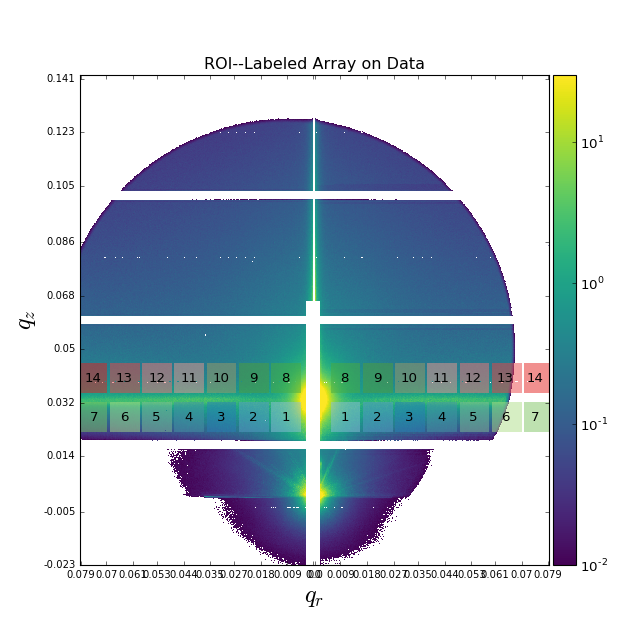

In [118]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uid   )

## Get 1D Curve (Q||-intensity¶)
* Users put cuts here for static analysis

The qr_edge is:  [ 0.005       0.015       0.01583333  0.02583333  0.02666667  0.03666667
  0.0375      0.0475      0.04833333  0.05833333  0.05916667  0.06916667
  0.07        0.08      ]
The qr_center is:  [ 0.01        0.02083333  0.03166667  0.0425      0.05333333  0.06416667
  0.075     ]
The qz_edge is:  [ 0.022  0.032  0.035  0.045]
The qz_center is:  [ 0.027  0.04 ]


<IPython.core.display.Javascript object>


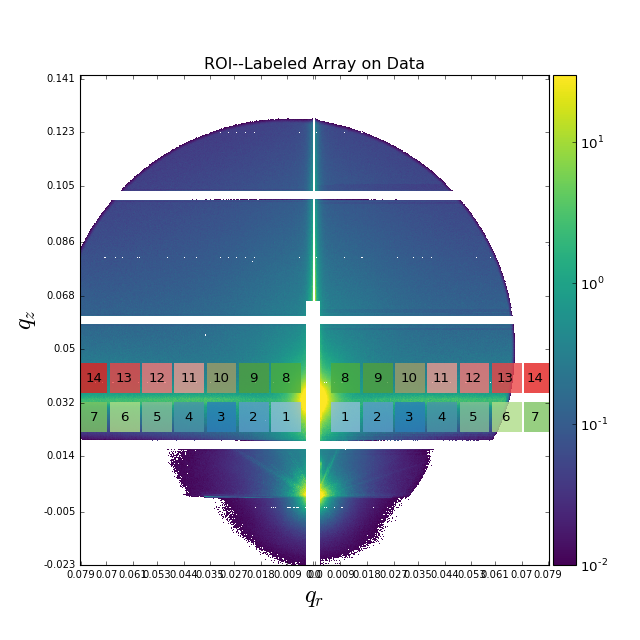

<IPython.core.display.Javascript object>


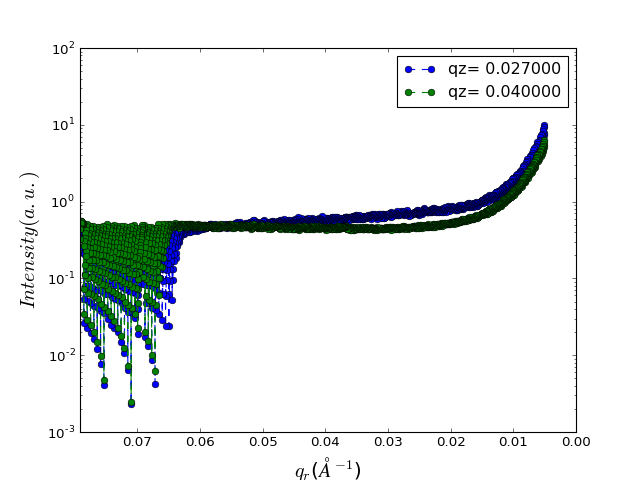

The qr_1d is saved in /XF11ID/analysis/2016_2/yuzhang/Results/35e040/ with filename as uid=35e040--qr_1d.csv


In [119]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  None,  True, ticks, .8,
                  save= True, setup_pargs=setup_pargs )

<IPython.core.display.Javascript object>


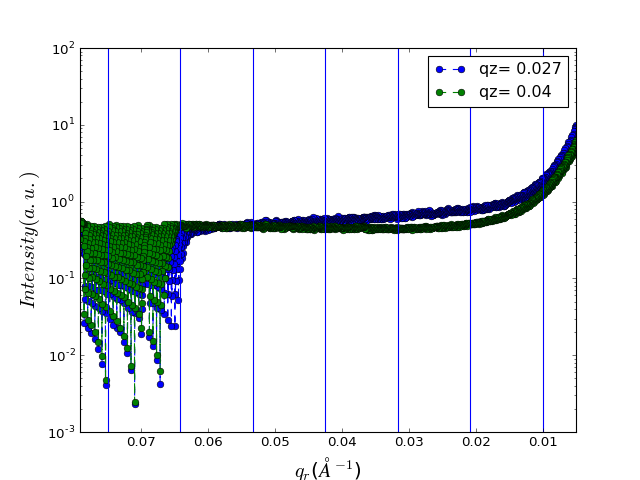

In [120]:
plot_qr_1d_with_ROI( qr_1d, qr_center, loglog=False, save=True, setup_pargs=setup_pargs )

* Check one box intensity 

<IPython.core.display.Javascript object>


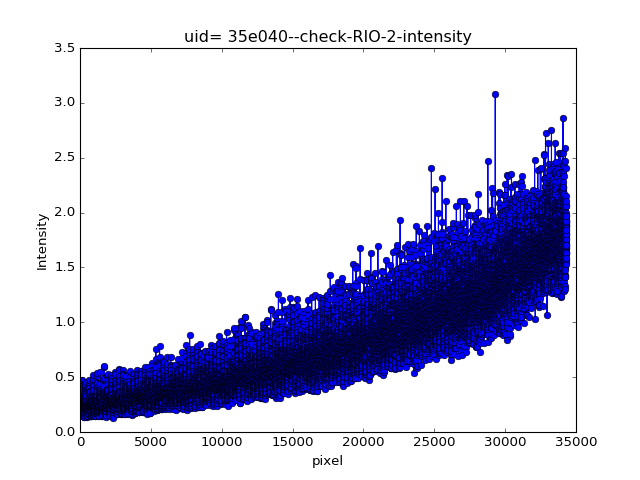

In [122]:
roi_inten = check_ROI_intensity( avg_imgr, box_maskr, ring_number= 2, uid =uid )

## Check beam damage
* do a waterfall analysis

In [123]:
if compress:
    qindex = 2
    wat = cal_waterfallc( FD, box_maskr, qindex= qindex, save =True, path=data_dir, uid=uid)   
    

Get waterfall for q index=2: 100%|██████████| 20000/20000 [02:46<00:00, 120.35it/s]


<IPython.core.display.Javascript object>


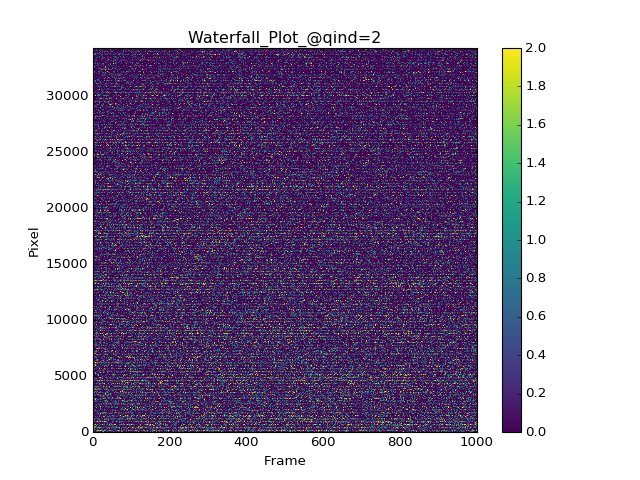

In [124]:
if compress:
    plot_waterfallc( wat[:1000], qindex, aspect=None,  vmax= 2, uid=uid, save =True, 
                    path=data_dir, beg= FD.beg)

* check mean intensity of each box as a function of time

Get ROI intensity of each frame: 100%|██████████| 20000/20000 [02:42<00:00, 123.18it/s]


<IPython.core.display.Javascript object>


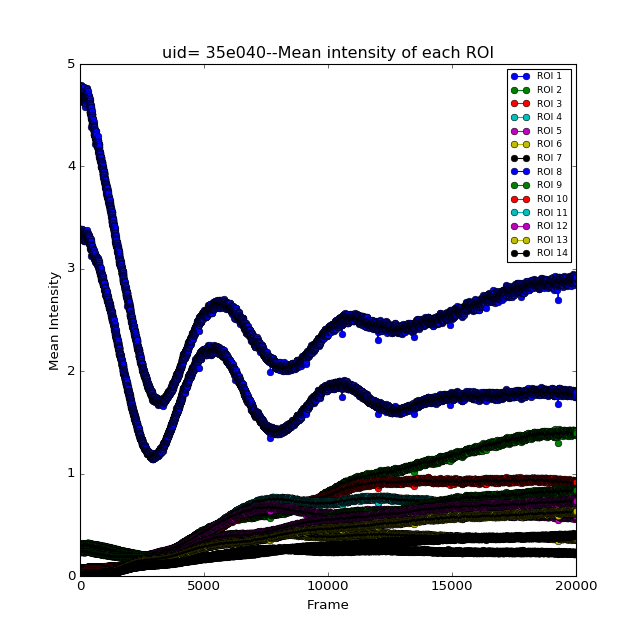

In [125]:
if compress:
    times, mean_int_sets = get_each_ring_mean_intensityc(FD, box_maskr,
                        timeperframe = None, plot_ = True, uid = uid , save=True, path=data_dir  )
    ring_avg = np.average( mean_int_sets, axis=0)
    
else:
    
    mean_int_sets = get_each_ring_mean_intensity(good_series, box_maskr, sampling = sampling,
                                timeperframe = md['frame_time']*sampling, plot_ = True, uid = uid  )

In [ ]:
#plot1D( x= range( len(mean_int_sets)), y= mean_int_sets[:,1])

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [195]:
if True:
    if compress:
        FD = Multifile(filename, 19000, len(imgs))
    else:
        good_start = 1
        good_end =  1000
        good_series = apply_mask( imgs[good_start:good_end-1], mask )

In [196]:
lag_steps = None

In [197]:
bad_frame_list

array([], dtype=int64)

In [198]:
para_cal = True   #False #True   #if True to use the parallel calculation

In [199]:
t0 = time.time()
if compress:
    if para_cal:
        g2, lag_steps  =cal_g2p( FD,  box_maskr, bad_frame_list, good_start, num_buf = 8, 
                        imgsum= None, norm=None )
    else:
        g2, lag_steps  =cal_g2c( FD,  box_maskr, bad_frame_list, good_start, num_buf = 8, 
                        imgsum= None, norm=None )        
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )    

    g2, lag_steps  =cal_g2( good_series,  box_maskr, bad_image_process,
                       bad_frame_list, good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--13--
20000 frames will be processed...



100%|██████████| 14/14 [00:02<00:00,  5.03it/s]


G2 calculation DONE!
Total time: 0.77 min


In [200]:
lag_steps

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  14,  16,
        20,  24,  28,  32,  40,  48,  56,  64,  80,  96, 112, 128, 160,
       192, 224, 256, 320, 384, 448, 512, 640, 768])

In [201]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,  path=data_dir, uid=uid )

In [202]:
save_gisaxs_g2(  g2, res_pargs )

The correlation function of uid= 35e040 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/35e040/g2-35e040-20160916-1814-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


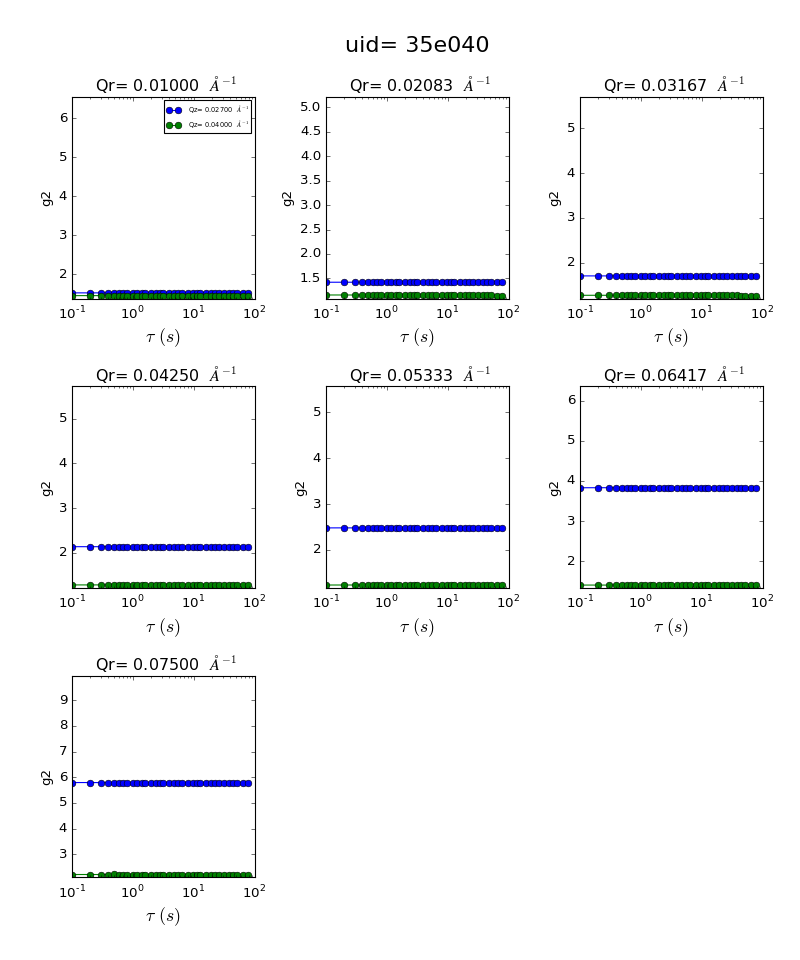

In [208]:
plot_gisaxs_g2( g2, taus,  vlim=[0.95, 4.5], res_pargs=res_pargs, one_plot=True)    

# Fit g2

In [209]:
fit= True

<IPython.core.display.Javascript object>


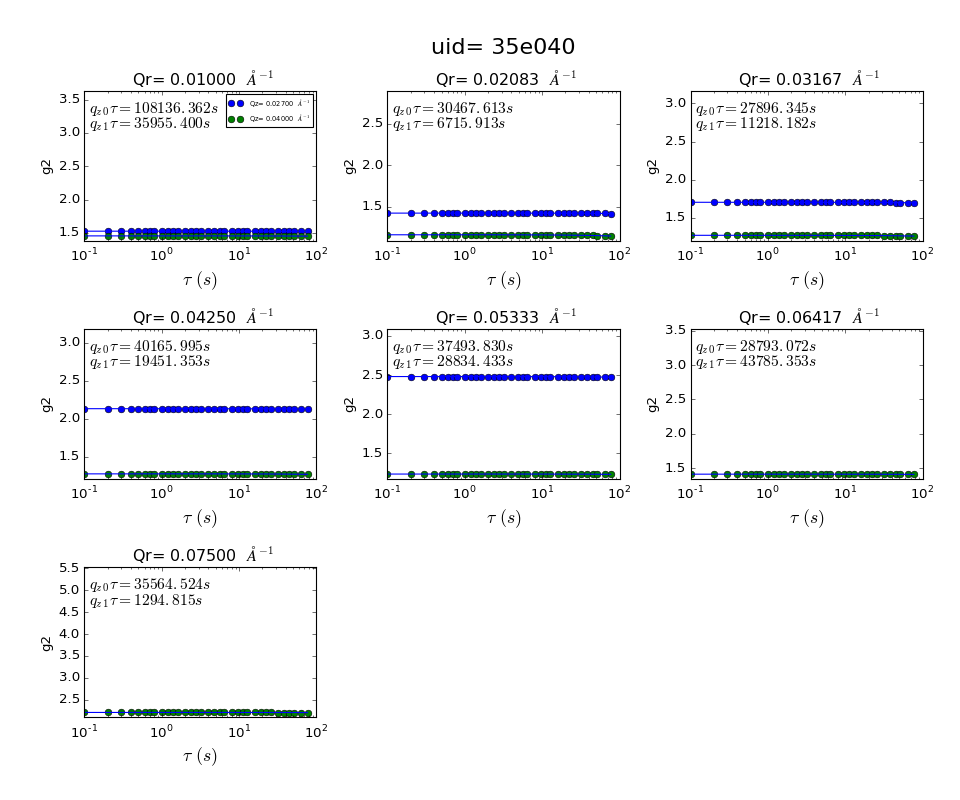

In [210]:
if fit:
    fit_result = fit_gisaxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 2.5], 
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                guess_values={'baseline':1.229,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01},
                              one_plot= True)

In [211]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

# Plot the relaxation time versus qr for different qz

The fitted diffusion coefficient D0 is:  7.737e-03   A^2S-1
The fitted diffusion coefficient D0 is:  7.828e-02   A^2S-1


<IPython.core.display.Javascript object>


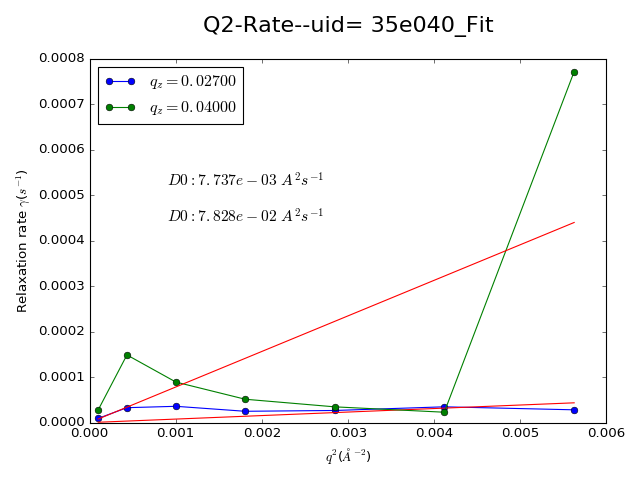

array([ 0.00773684,  0.07827539])

In [212]:
fit_qr_qz_rate(  qr_center, qz_center, fit_result, power_variable= False,
           uid=uid, path= data_dir )

# For two-time

In [213]:
#if compress:
#    FD = Multifile(filename, 0, Nimg)

In [214]:
run_two_time =  True

In [215]:
para_cal = True  #False #True 

In [246]:
if run_two_time:
    
    if compress:
        norm = None
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()
        

100%|██████████| 1000/1000 [00:12<00:00, 101.21it/s]


In [248]:
if run_two_time:    
    if compress:
        if para_cal:
            g12b = auto_two_Arrayp(  data_pixel,  box_maskr, index = None   )    
        else:    
            g12b = auto_two_Arrayc(  data_pixel,  box_maskr, index = None   ) 
           
        if lag_steps is None:
            num_bufs=8
            noframes = FD.end - FD.beg
            num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
            tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
            max_taus= lag_steps.max()
    else:
        qind, pixelist = roi.extract_label_indices(   box_maskr  )
        t0 = time.time()
        data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
        run_time(t0)
        g12b = auto_two_Array( good_series, box_maskr, data_pixel = data_pixel ) 
        
        

100%|██████████| 14/14 [00:19<00:00,  1.52s/it]


G12 calculation DONE!


<IPython.core.display.Javascript object>


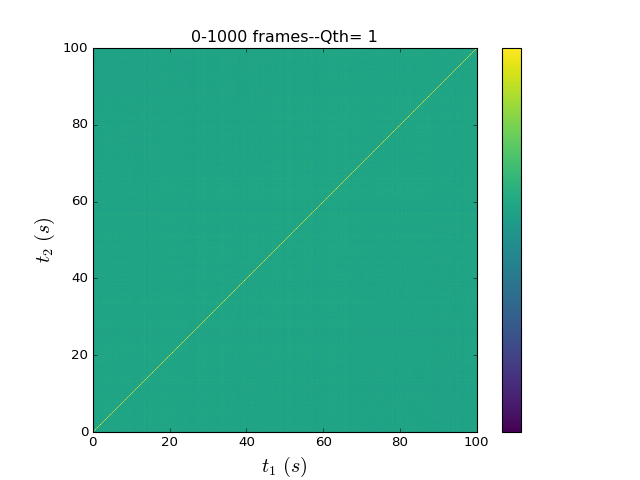

In [251]:
if run_two_time:
    show_C12(g12b, q_ind= 1, N1=0, N2=1000, vmin=1.01, vmax=1.8,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid ) 

In [252]:
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
    
    max_taus= lag_steps.max()
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe

    res_pargs2 = dict(taus=taus2, qz_center=qz_center, qr_center=qr_center,
             path=data_dir, uid=uid + 'g2_from_two-time'        )        
    save_gisaxs_g2(  g2b, res_pargs2,  taus=np.arange( g2b.shape[0]) *timeperframe,
                 filename='g2_from_two-time')



Total time: 0.00 min
The correlation function of uid= 35e040g2_from_two-time is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/35e040/g2_from_two-time


<IPython.core.display.Javascript object>


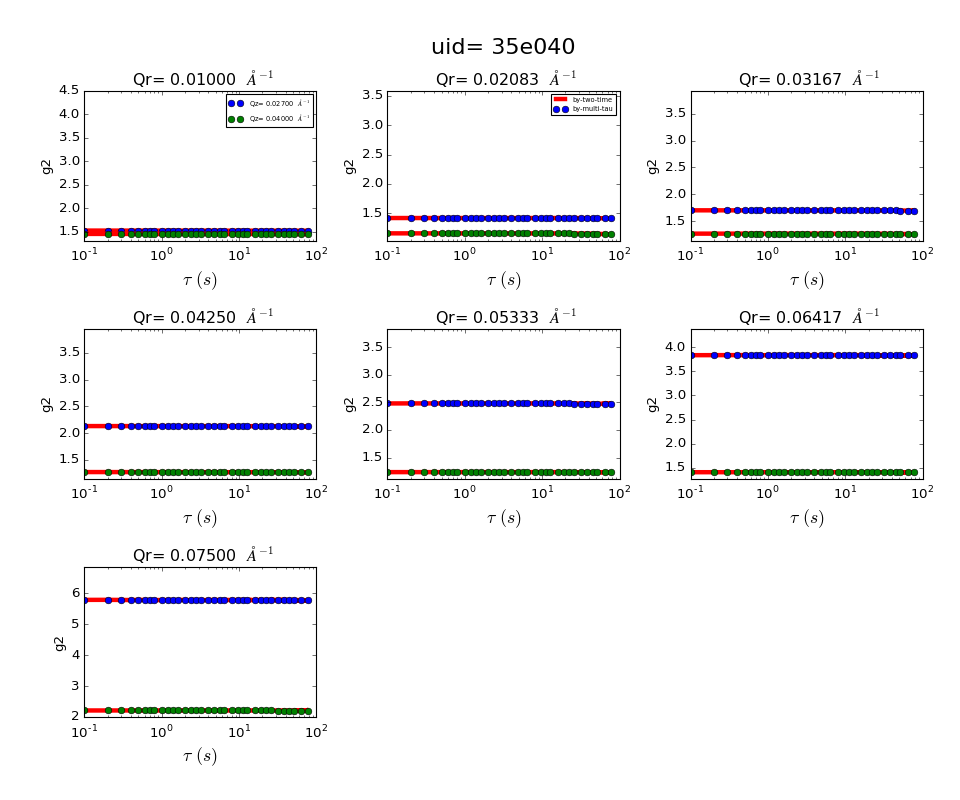

In [253]:
if run_two_time:
    plot_gisaxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.9, 3.1],one_plot= True, uid =uid )

# Four Time Correlation

In [254]:
run_four_time = True

In [255]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

Total time: 0.00 min


In [256]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, qz_center=qz_center, qr_center=qr_center, path=data_dir, uid=uid )
    save_gisaxs_g2(   g4,  res_pargs4,   filename='uid=%s--g4.csv' % (uid) )

The correlation function of uid= 35e040 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/35e040/uid=35e040--g4.csv


In [257]:
#g12b.shape

<IPython.core.display.Javascript object>


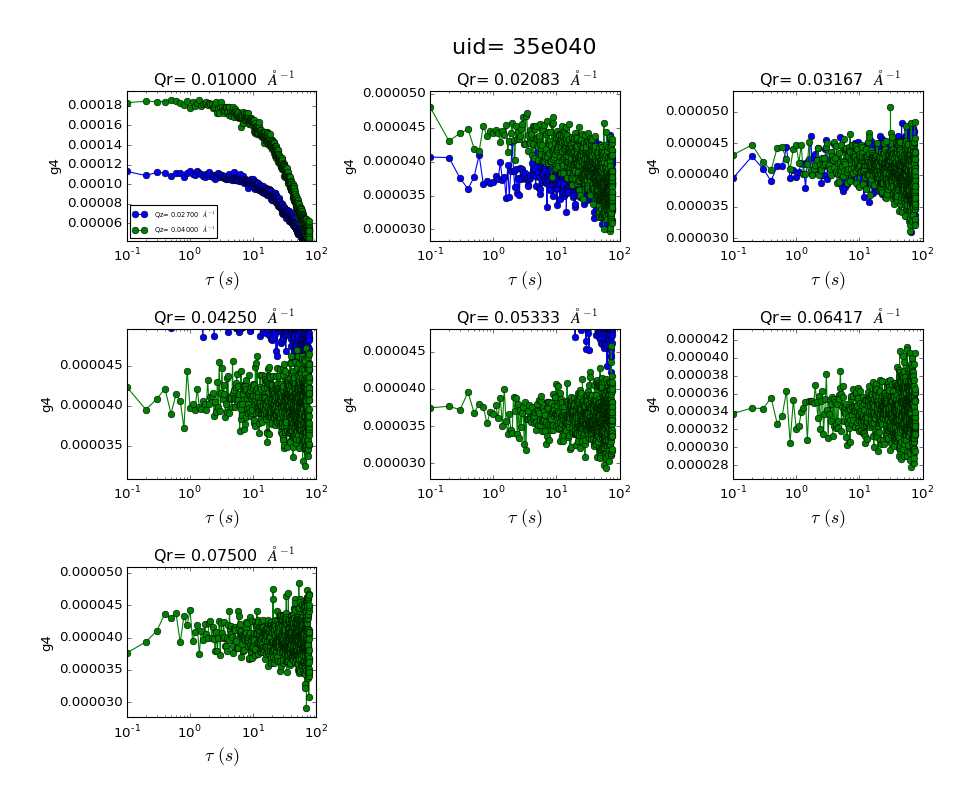

In [258]:
 if run_four_time:
        plot_gisaxs_g4( g4, taus4,  vlim=[0.95, 1.05], res_pargs=res_pargs, one_plot= True)  

# The End!

In [259]:
create_report = True

In [260]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [261]:
if create_report:
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,
                    filename= "XPCS_Analysis_Report_for_uid=%s.pdf"%uid, report_type='gisaxs')
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560, iq_fit =None )
    c.report_ROI( top= 300)
    
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)  
    
    #Page Three: two-time/two g2
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )      

    if run_four_time:
        c.new_page()
        c.report_header(page=4)
        c.report_four_time(  top= 720 ) 
        
        
    c.save_page()
    c.done()        



****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=35e040.pdf
****************************************


## Attach the PDF report to Olog 

In [ ]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [ ]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [ ]:
c.filename

In [ ]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 

update_olog_uid( uid=uid, text='Add XPCS Analysis PDF Report', attachments= atch )

## Attach the Analysis Notebook to Olog 

In [ ]:
NOTEBOOK_FULL_PATH

In [ ]:
note_path = '2016_2/yuzhang/August/XPCS_GiSAXS_Single_Run_Sep.ipynb'

In [ ]:
filename = '/XF11ID/analysis/'+ note_path #NOTEBOOK_FULL_PATH

atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid, text='Add XPCS Analysis notebook', attachments= atch )